In [1]:
# Import Libraries
import numpy as np 
import pandas as pd 
import time
import itertools

# file system libraries
import os
import os.path
from   os import path
import shutil

# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Images, Plotting
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# tensorflow - CNNs
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121,InceptionV3, Xception, ResNet101
from kerastuner.tuners import Hyperband

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


## Dataset Maker

In [2]:
dirs = ['../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented',
           '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/ModerateDemented',
           '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/VeryMildDemented']
all_file_paths = []
    
for cur_dir in dirs:
    file_names = os.listdir(cur_dir)
    file_paths = [os.path.join(cur_dir,file_name) for file_name in file_names]
    all_file_paths += file_paths
print(f'total files {len(all_file_paths)}')
train_dataset = tf.data.Dataset.from_tensor_slices(all_file_paths)
print('train dataset loaded')

total files 2561


2022-12-10 08:52:36.444939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 08:52:36.445876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 08:52:36.594488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 08:52:36.595543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 08:52:36.596370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

train dataset loaded


2022-12-10 08:52:36.601757: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 08:52:36.856430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 08:52:36.857230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 08:52:36.858005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [38]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [128,128])
    image /= 255.0  # normalize to [0,1] range
    return image
train_dataset = train_dataset.map(load_and_preprocess_image)
batch_size = 16
train_dataset = train_dataset.shuffle(10 * batch_size).batch(batch_size, drop_remainder=True).prefetch(buffer_size=50)

In [4]:
for idx,temp in enumerate(train_dataset):
    continue
steps_per_epoch = idx+1
standard = 50 * 160
epochs = standard // steps_per_epoch
steps_per_epoch, epochs

2022-12-10 08:52:40.396216: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(160, 50)

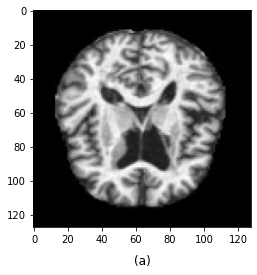

In [5]:
plt.imshow(temp[0,:,:,0],cmap='gray')
plt.title('(a)',y=-0.2)
plt.savefig('original.png',dpi=300)

## Training

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from sklearn.utils import shuffle
import numpy as np
import os

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(512*8, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512*8*8, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8,8,512)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.Activation('sigmoid'))
    return model

In [8]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             134217728 
_________________________________________________________________
batch_normalization_1 (Batch (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input((128,128,1)))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))



    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1664      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)      

In [11]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 100

In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
import time

def train(dataset, epochs):
  total = 0
  for epoch in range(epochs):
    start = time.time()
    total = 0
    for image_batch in dataset:
      
      train_step(image_batch)
      total+=1
      if total == steps_per_epoch:
        total=0
        break

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    total += time.time()-start
    print ('Time for epoch {} is {} sec and total {} sec'.format(epoch + 1, time.time()-start,total))

In [21]:
train(train_dataset,epochs)

Time for epoch 1 is 17.67982029914856 sec and total 17.67981767654419 sec
Time for epoch 2 is 17.412556648254395 sec and total 17.412554025650024 sec
Time for epoch 3 is 17.135629892349243 sec and total 17.135627031326294 sec
Time for epoch 4 is 17.03206706047058 sec and total 17.03206467628479 sec
Time for epoch 5 is 17.10195517539978 sec and total 17.101952075958252 sec
Time for epoch 6 is 17.232783317565918 sec and total 17.232780694961548 sec
Time for epoch 7 is 17.22809648513794 sec and total 17.22809338569641 sec
Time for epoch 8 is 17.174221992492676 sec and total 17.174219369888306 sec
Time for epoch 9 is 17.12861180305481 sec and total 17.12860941886902 sec
Time for epoch 10 is 17.144941329956055 sec and total 17.144937992095947 sec
Time for epoch 11 is 17.17626976966858 sec and total 17.17626714706421 sec
Time for epoch 12 is 17.180227041244507 sec and total 17.180224418640137 sec
Time for epoch 13 is 17.19696044921875 sec and total 17.1969575881958 sec
Time for epoch 14 is 1

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))  

In [39]:
for idx,temp in enumerate(train_dataset):
    
    if idx == 0:
        save_images = np.copy(temp)
        continue
    save_images = np.concatenate((save_images,temp))
    

In [40]:
from sklearn.utils import shuffle

save_images = shuffle(save_images)
save_images = shuffle(save_images)

np.save('none_dementia_alzheimer.npy',save_images[:100])

In [26]:
noise = tf.random.normal([16, 100])
generated = generator.predict(noise)

In [27]:
np.min(generated), np.max(generated)


(4.6635343e-12, 0.9965167)

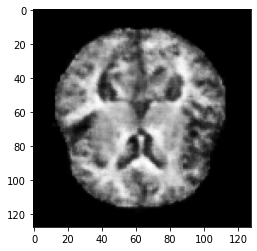

In [28]:
import matplotlib.pyplot as plt
plt.imshow(generated[4,:,:,0],cmap='gray')
plt.savefig('3.png')

In [29]:
generator.save_weights('Gan1-dementia-generator.h5')
discriminator.save_weights('Gan1-dementia-discriminator.h5')

## Load weights

In [17]:
generator.load_weights('../input/diffusionmodelweights/normal_generator.h5')

In [18]:
noise = tf.random.normal([16, 100])

In [19]:
predictions = generator.predict(noise)

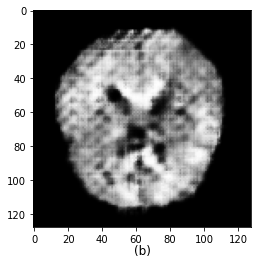

In [21]:
plt.imshow(predictions[0,:,:,0],cmap='gray')
plt.title('(b)',y=-0.155)
plt.savefig('normal_gan.png',dpi=300)